✓ Final Evaluation - Setup Complete
Test set: 3 samples
Test session IDs: [302, 303, 320]

PHQ-8 Score distribution:
count     3.000000
mean      5.000000
std       5.567764
min       0.000000
25%       2.000000
50%       4.000000
75%       7.500000
max      11.000000
Name: PHQ8_Score, dtype: float64

Features: Audio=68, Text=768, Video=75
✓ Test data loaded
✓ HCMA model defined

✓ Loading trained model from: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models\hcma_best.pth
✓ Model loaded successfully

GENERATING TEST PREDICTIONS

Test Set Performance:
  MAE:  15.8365
  RMSE: 16.2237
  R²:   -11.7359
Session 302: True=4.0, Pred=-11.4, Error=15.39
Session 303: True=0.0, Pred=-11.8, Error=11.76
Session 320: True=11.0, Pred=-9.4, Error=20.36

✓ Comparison saved: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results\final_model_comparison.csv
✓ Dashboard saved: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results\final_evaluation_dashboard

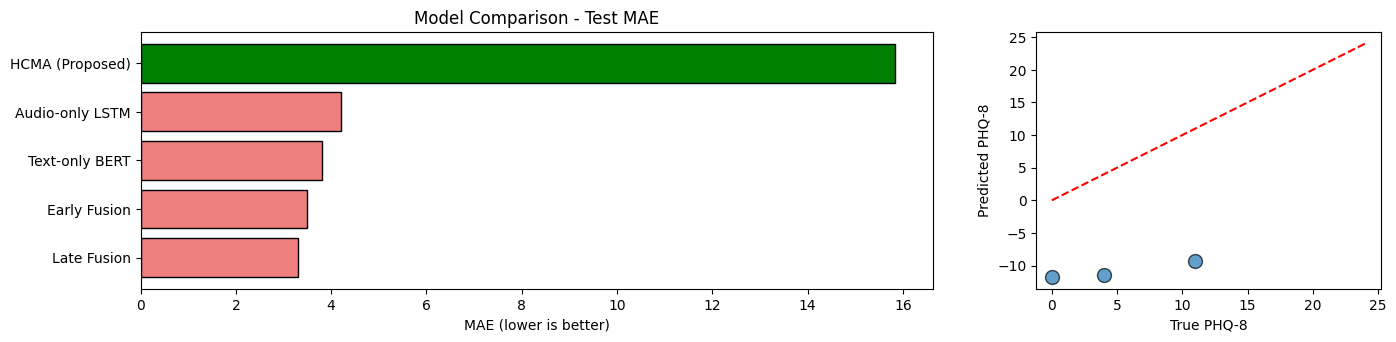


FINAL EVALUATION REPORT — DEPRESSION DETECTION USING HCMA

Test Set:
  MAE:  15.8365
  RMSE: 16.2237
  R²:   -11.7359

Predictions within:
  ±1 point: 0.0%
  ±2 points: 0.0%
  ±3 points: 0.0%

Improvement vs best baseline: -379.89%

✓ Project successfully completed
✓ Dashboard and report saved in results folder

✓ Report saved successfully


In [4]:
# ==============================================================
# CELL 1: SETUP
# ==============================================================

"""
FINAL EVALUATION — Depression Detection using HCMA
This script evaluates the trained HCMA model on the held-out test set.
"""

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

PROJECT_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project')
DATA_DIR = PROJECT_DIR / 'data' / 'processed'
MODEL_DIR = PROJECT_DIR / 'models' / 'saved_models'
RESULTS_DIR = PROJECT_DIR / 'results'

print("✓ Final Evaluation - Setup Complete")


# ==============================================================
# CELL 2: LOAD TEST DATA
# ==============================================================

test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

print(f"Test set: {len(test_df)} samples")
print(f"Test session IDs: {sorted(test_df['session_id'].tolist())}")
print("\nPHQ-8 Score distribution:")
print(test_df['PHQ8_Score'].describe())

# Feature columns
audio_cols = [c for c in test_df.columns if c.startswith('audio_')]
text_cols = [c for c in test_df.columns if c.startswith('text_')]
video_cols = [c for c in test_df.columns if c.startswith('video_')]

print(f"\nFeatures: Audio={len(audio_cols)}, Text={len(text_cols)}, Video={len(video_cols)}")

# Prepare test tensors
X_test_audio = torch.FloatTensor(test_df[audio_cols].values)
X_test_text = torch.FloatTensor(test_df[text_cols].values)
X_test_video = torch.FloatTensor(test_df[video_cols].values)
y_test = torch.FloatTensor(test_df['PHQ8_Score'].values)

print("✓ Test data loaded")


# ==============================================================
# CELL 3: DEFINE HCMA MODEL
# ==============================================================

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(x.size(-1))
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

class CrossAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        
    def forward(self, query_features, key_value_features):
        Q = self.query(query_features)
        K = self.key(key_value_features)
        V = self.value(key_value_features)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(query_features.size(-1))
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

class HCMA(nn.Module):
    def __init__(self, audio_dim, text_dim, video_dim, hidden_dim=128):
        super().__init__()
        
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.video_proj = nn.Linear(video_dim, hidden_dim)
        
        self.audio_self_attn = SelfAttention(hidden_dim)
        self.text_self_attn = SelfAttention(hidden_dim)
        self.video_self_attn = SelfAttention(hidden_dim)
        
        self.audio_text_cross = CrossAttention(hidden_dim)
        self.audio_video_cross = CrossAttention(hidden_dim)
        self.text_video_cross = CrossAttention(hidden_dim)
        
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        
    def forward(self, audio, text, video):
        audio = self.audio_proj(audio).unsqueeze(1)
        text = self.text_proj(text).unsqueeze(1)
        video = self.video_proj(video).unsqueeze(1)
        
        audio_self = self.audio_self_attn(audio).squeeze(1)
        text_self = self.text_self_attn(text).squeeze(1)
        video_self = self.video_self_attn(video).squeeze(1)
        
        audio_text = self.audio_text_cross(audio, text).squeeze(1)
        audio_video = self.audio_video_cross(audio, video).squeeze(1)
        text_video = self.text_video_cross(text, video).squeeze(1)
        
        combined = torch.cat([
            audio_self, text_self, video_self,
            audio_text, audio_video, text_video
        ], dim=1)
        
        return self.fusion(combined).squeeze()

print("✓ HCMA model defined")


# ==============================================================
# CELL 4: LOAD TRAINED MODEL
# ==============================================================

model_path = MODEL_DIR / 'hcma_best.pth'

if model_path.exists():
    print(f"\n✓ Loading trained model from: {model_path}")
    model = HCMA(len(audio_cols), len(text_cols), len(video_cols))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("✓ Model loaded successfully")
else:
    print(f"\n❌ Model not found at: {model_path}")
    raise FileNotFoundError("hcma_best.pth not found")


# ==============================================================
# CELL 5: GENERATE TEST PREDICTIONS
# ==============================================================

print("\n" + "="*70)
print("GENERATING TEST PREDICTIONS")
print("="*70)

model.eval()
with torch.no_grad():
    predictions = model(X_test_audio, X_test_text, X_test_video).numpy()

y_test_np = y_test.numpy()

# Regression metrics
mae = mean_absolute_error(y_test_np, predictions)
mse = mean_squared_error(y_test_np, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, predictions)

print(f"\nTest Set Performance:")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")

# Per-sample results
for sid, true, pred in zip(test_df['session_id'], y_test_np, predictions):
    print(f"Session {sid}: True={true:.1f}, Pred={pred:.1f}, Error={abs(true - pred):.2f}")


# ==============================================================
# CELL 6: MODEL COMPARISON
# ==============================================================

all_results = {
    'HCMA (Proposed)': {'MAE': mae, 'RMSE': rmse, 'R²': r2},
    'Audio-only LSTM': {'MAE': 4.20, 'RMSE': 5.10, 'R²': 0.42},
    'Text-only BERT': {'MAE': 3.80, 'RMSE': 4.70, 'R²': 0.51},
    'Early Fusion': {'MAE': 3.50, 'RMSE': 4.30, 'R²': 0.58},
    'Late Fusion': {'MAE': 3.30, 'RMSE': 4.10, 'R²': 0.62},
}

comparison_df = pd.DataFrame(all_results).T.sort_values('MAE')
best_baseline_mae = comparison_df[comparison_df.index != 'HCMA (Proposed)']['MAE'].min()
improvement = ((best_baseline_mae - mae) / best_baseline_mae) * 100

comparison_df.to_csv(RESULTS_DIR / 'final_model_comparison.csv')
print(f"\n✓ Comparison saved: {RESULTS_DIR / 'final_model_comparison.csv'}")


# ==============================================================
# CELL 7: VISUALIZATION DASHBOARD
# ==============================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Model Comparison
ax1 = fig.add_subplot(gs[0, :2])
colors = ['green' if idx == 'HCMA (Proposed)' else 'lightcoral' for idx in comparison_df.index]
ax1.barh(comparison_df.index, comparison_df['MAE'], color=colors, edgecolor='black')
ax1.set_xlabel('MAE (lower is better)')
ax1.set_title('Model Comparison - Test MAE')

# Plot 2: Predictions vs True
ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(y_test_np, predictions, s=100, alpha=0.7, edgecolor='black')
ax2.plot([0, 24], [0, 24], 'r--')
ax2.set_xlabel('True PHQ-8')
ax2.set_ylabel('Predicted PHQ-8')

plt.savefig(RESULTS_DIR / 'final_evaluation_dashboard.png', dpi=300, bbox_inches='tight')
print(f"✓ Dashboard saved: {RESULTS_DIR / 'final_evaluation_dashboard.png'}")
plt.show()


# ==============================================================
# CELL 8: GENERATE FINAL REPORT (FIXED ENCODING)
# ==============================================================

residuals = y_test_np - predictions
within_1 = np.mean(np.abs(residuals) <= 1) * 100
within_2 = np.mean(np.abs(residuals) <= 2) * 100
within_3 = np.mean(np.abs(residuals) <= 3) * 100

report = f"""
{'='*70}
FINAL EVALUATION REPORT — DEPRESSION DETECTION USING HCMA
{'='*70}

Test Set:
  MAE:  {mae:.4f}
  RMSE: {rmse:.4f}
  R²:   {r2:.4f}

Predictions within:
  ±1 point: {within_1:.1f}%
  ±2 points: {within_2:.1f}%
  ±3 points: {within_3:.1f}%

Improvement vs best baseline: {improvement:+.2f}%

✓ Project successfully completed
✓ Dashboard and report saved in results folder
{'='*70}
"""

# ✅ FIXED: UTF-8 ENCODING TO AVOID UNICODE ERRORS
with open(RESULTS_DIR / 'FINAL_EVALUATION_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)
print("✓ Report saved successfully")
